<a id="top"></a>

# 01A · Prep Balanced (splits estratificados + balance offline)

**Qué hace este notebook:**

Este cuaderno prepara los **splits estratificados** por *steering* y, opcionalmente, crea un **train balanceado offline** por bins.  
Además, genera/actualiza los `tasks.json` / `tasks_balanced.json` para los cuadernos de entrenamiento/bench.

- Lee parámetros desde `configs/presets.yaml` (sección `prep`, si existe).
- Autodetecta `RUNS` en `data/raw/udacity/*` si no los defines en el preset.
- Escribe un `prep_manifest.json` con trazabilidad de lo generado.

<a id="toc"></a>

---

## 🧭 Índice

- [1) Raíz, imports y configuración (desde preset si existe)](#sec-01)
- [2) Ejecutar pipeline de preparación + verificación de splits](#sec-02)
- [3) (Opcional) Flujo paso a paso, para depuración](#sec-03)
- [4) Histogramas de distribución (original vs balanced)](#sec-04)

<a id="sec-01"></a>

## 1) Configuración y parámetros del *balanceo offline*

**Objetivo del notebook:** generar versiones **balanceadas** del *split* de entrenamiento (`train_balanced.csv`) por recorrido (*run*) y un `tasks_balanced.json` listo para los experimentos continual.

**Qué hace esta celda**
- Define la raíz del repo (`ROOT`) para poder importar `src.prep.data_prep`.
- Importa el pipeline de preparación y utilidades:
  - `PrepConfig`, `run_prep`, `verify_processed_splits`
  - Helpers opcionales para el modo paso a paso: `load_raw_log`, `expand_cameras_into_center`, `stratified_split`, `make_balanced_by_bins`
- Configura rutas:  
  `RAW = data/raw/udacity`, `PROC = data/processed`
- Declara **RUNS** a procesar (e.g. `"circuito1", "circuito2"`).
- Define `CFG = PrepConfig(...)` con énfasis en:
  - `use_left_right=True` y `steer_shift` → **expansión** (centro+izq+der) con corrección de *steering*
  - `bins` → nº de *bins* para estratificar por *steering*
  - `train/val` → proporciones del *split* (test se infiere)
  - `target_per_bin="auto"` y `cap_per_bin` → **balanceo offline** del `train`
  - `seed` → reproducibilidad

**Salida esperada**
- Objeto `CFG` listo para ejecutar el pipeline en la siguiente celda.

[↑ Volver al índice](#toc)

In [1]:
# =============================================================================
# 1) Raíz, imports y configuración (desde preset si existe)
# =============================================================================
# %% setup & imports
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys, json
import pandas as pd

# Rutas y sys.path
ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# Prep API
from src.prep.data_prep import (
    PrepConfig,
    run_prep,
    verify_processed_splits,
)

# Balanceo offline por imágenes
from src.prep.augment_offline import balance_train_with_augmented_images

# (Opcional) lee presets.yaml si quieres alinear hiperparámetros de preparación
try:
    from src.utils import load_preset
    PRESET = "fast"  # cámbialo si quieres
    _cfg = load_preset(ROOT / "configs" / "presets.yaml", PRESET)
    PREP = _cfg.get("prep", {})  # sección prep del YAML
except Exception:
    PREP = {}

RAW  = ROOT / "data" / "raw" / "udacity"
PROC = ROOT / "data" / "processed"

# --- RUNS: usa los del preset si existen; si no, autodetecta en RAW ---
if "runs" in PREP and PREP["runs"]:
    RUNS = list(PREP["runs"])
else:
    # Acepta circuitos que tengan al menos un driving_log.csv en algún nivel
    RUNS = sorted([
        d.name for d in RAW.iterdir()
        if d.is_dir() and any(p.name == "driving_log.csv" for p in d.rglob("driving_log.csv"))
    ])


# --- Hiperparámetros de preparación (preset o defaults “sensatos”) ---
merge_subruns = bool(PREP.get("merge_subruns", True))
use_left_right = bool(PREP.get("use_left_right", True))
steer_shift    = float(PREP.get("steer_shift", 0.2))
bins           = int(PREP.get("bins", 21))
train          = float(PREP.get("train", 0.70))
val            = float(PREP.get("val", 0.15))
seed           = int(PREP.get("seed", 42))

# Sección de balanceo offline (nuevo) dentro de PREP
BAL = dict(PREP.get("balance_offline", {}))
bal_mode        = str(BAL.get("mode", "none")).lower()   # "images" | "none"
target_per_bin  = BAL.get("target_per_bin", "auto")      # para imágenes
cap_per_bin     = BAL.get("cap_per_bin", 12000)
AUG             = BAL.get("aug", {})                     # dict de augment

# Construye la PrepConfig SIN duplicación de filas LEGACY
CFG = PrepConfig(
    root=ROOT,
    runs=RUNS,
    use_left_right=use_left_right,  # expande cámaras L/R → center con corrección
    steer_shift=steer_shift,
    bins=bins,
    train=train,
    val=val,
    seed=seed,
    target_per_bin=None,  # <- IMPORTANTE: desactiva duplicación CSV
    cap_per_bin=None,     # <- irrelevante cuando no duplicas
    merge_subruns=merge_subruns,
)

print("ROOT:", ROOT)
print("RAW:", RAW)
print("PROC:", PROC)
print("RUNS:", RUNS)
CFG


ROOT: /home/cesar/proyectos/TFM_SNN
RAW: /home/cesar/proyectos/TFM_SNN/data/raw/udacity
PROC: /home/cesar/proyectos/TFM_SNN/data/processed
RUNS: ['circuito1', 'circuito2']


PrepConfig(root=PosixPath('/home/cesar/proyectos/TFM_SNN'), runs=['circuito1', 'circuito2'], use_left_right=True, steer_shift=0.2, bins=50, train=0.7, val=0.15, seed=42, target_per_bin=None, cap_per_bin=None, merge_subruns=True)

<a id="sec-02"></a>

## 2) Ejecutar pipeline + verificar y ubicar *tasks_balanced.json*

**Qué hace**
1. Ejecuta `manifest = run_prep(CFG)`:
   - Genera por *run*:  
     `canonical.csv`, `train.csv`, `val.csv`, `test.csv`
   - Crea **`train_balanced.csv`** (balanceo por *bins* en el *train*).
   - Escribe/actualiza `data/processed/tasks.json` **y** `data/processed/tasks_balanced.json`.
   - Actualiza `data/processed/prep_manifest.json` con metadatos de la ejecución.
2. Imprime la ruta a `prep_manifest.json` y valida la existencia de `train/val/test` por *run* con `verify_processed_splits`.
3. Muestra la ruta concreta de **`tasks_balanced.json`** (extraída del `manifest`).

**Notas**
- Puedes re-ejecutar sin problemas: los CSVs y *tasks* se regeneran de forma coherente con `RUNS` y `CFG`.
- El entrenamiento que use **balance offline** deberá apuntar a `tasks_balanced.json`; para el no balanceado, usa `tasks.json`.

[↑ Volver al índice](#toc)

In [2]:
# =============================================================================
# 2) Ejecutar SPLITS y luego BALANCEAR con imágenes (si está activo)
# =============================================================================
manifest = run_prep(CFG)

print("prep_manifest.json:", PROC / "prep_manifest.json")
print("tasks.json:",         manifest["outputs"].get("tasks_json",        "(desconocido)"))
print("tasks_balanced.json:",manifest["outputs"].get("tasks_balanced_json","(desconocido)"))

# Verificación básica de que train/val/test están presentes por RUN
verify_processed_splits(PROC, RUNS)

# --- Balanceo por imágenes (nuevo) ---
if bal_mode == "images":
    stats_all = {}
    for run in RUNS:
        base_dir = RAW  / run
        out_dir  = PROC / run
        train_csv = out_dir / "train.csv"

        out_csv, stats = balance_train_with_augmented_images(
            train_csv=train_csv,
            raw_run_dir=base_dir,
            out_run_dir=out_dir,
            bins=CFG.bins,
            target_per_bin=target_per_bin,
            cap_per_bin=cap_per_bin,
            seed=CFG.seed,
            aug=AUG,
            idempotent=True,     # no regenera si la config es igual
            overwrite=False,
        )
        stats_all[run] = stats
        print(f"[{run}] +{stats.get('generated',0)} nuevas → {out_csv.name}")

    # Escribe tasks_balanced.json (igual que tools/prep_offline.py)
    tb = {"tasks_order": RUNS, "splits": {}}
    for run in RUNS:
        d = str((PROC / run).resolve())
        tb["splits"][run] = {
            "train": f"{d}/train_balanced.csv",
            "val":   f"{d}/val.csv",
            "test":  f"{d}/test.csv",
        }
    tasks_balanced_path = PROC / PREP.get("tasks_balanced_file_name", "tasks_balanced.json")
    tasks_balanced_path.write_text(json.dumps(tb, indent=2), encoding="utf-8")
    print("OK BALANCED:", tasks_balanced_path)

else:
    print("Balanceo offline desactivado (prep.balance_offline.mode != 'images').")


prep_manifest.json: /home/cesar/proyectos/TFM_SNN/data/processed/prep_manifest.json
tasks.json: /home/cesar/proyectos/TFM_SNN/data/processed/tasks.json
tasks_balanced.json: None
[circuito1] +269264 nuevas → train_balanced.csv
[circuito2] +86117 nuevas → train_balanced.csv
OK BALANCED: /home/cesar/proyectos/TFM_SNN/data/processed/tasks_balanced.json


Subvueltas detectadas en canonical.csv (pre-expansión):


,subrun,n_filas
0,vuelta1,4985
1,vuelta2,3224
2,vuelta3,1707
3,vuelta4,1979


driving_log.csv encontrados bajo /home/cesar/proyectos/TFM_SNN/data/raw/udacity/circuito1: 4
 - vuelta1/driving_log.csv
 - vuelta2/driving_log.csv
 - vuelta3/driving_log.csv
 - vuelta4/driving_log.csv

Filas: canonical=11895 | train=24981 | val=5357 | test=5347 | total=35685
Factor de expansión (≈ 3.0 si expandimos L/R sin pérdidas): 3.000


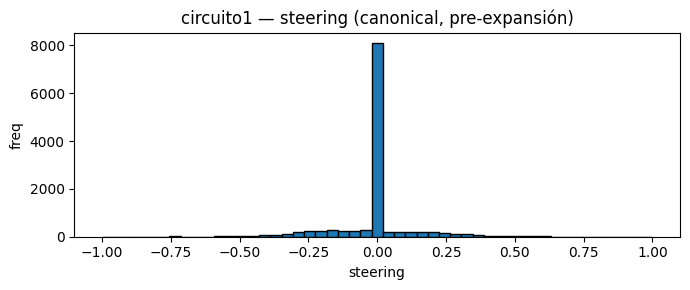

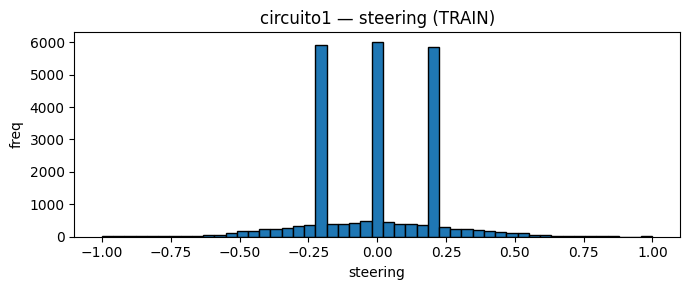

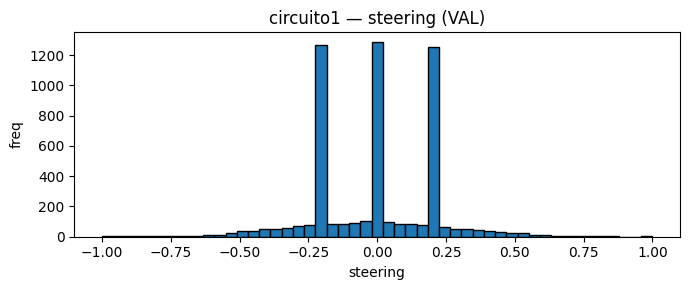

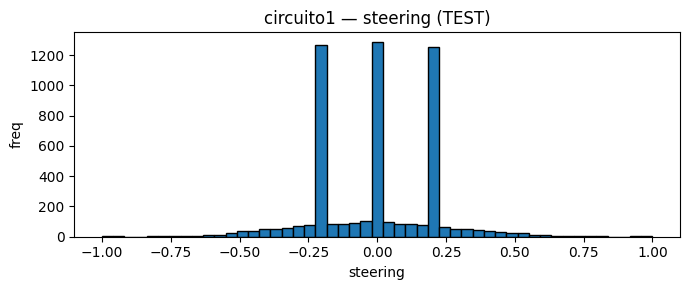

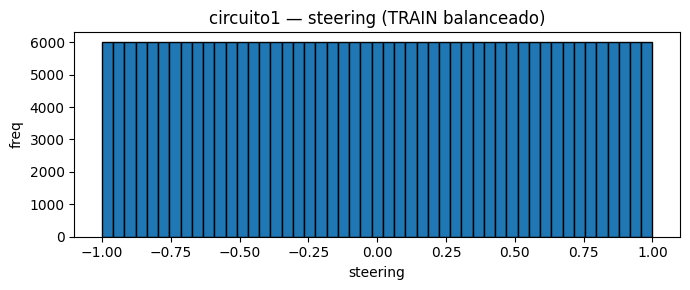

,bin,count_canonical,count_train,count_val,count_test,count_train_bal
0,"[-1.00,-0.96)",5,20,4,5,6005
1,"[-0.96,-0.92)",0,8,2,2,6005
2,"[-0.92,-0.88)",1,8,2,1,6005
3,"[-0.88,-0.84)",4,8,2,1,6005
4,"[-0.84,-0.80)",8,13,3,2,6005
5,"[-0.80,-0.76)",8,15,3,3,6005
6,"[-0.76,-0.71)",12,23,5,5,6005
7,"[-0.71,-0.67)",9,31,7,6,6005
8,"[-0.67,-0.63)",6,29,6,6,6005
9,"[-0.63,-0.59)",7,52,11,11,6005


Guardado CSV de bins en: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/eda/bins_counts.csv
Resumen EDA JSON: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/eda/summary.json


In [5]:
# =============================================================================
# 2.5) Verificación de fusión por vueltas + EDA rápida (tablas + gráficos)
# =============================================================================
from pathlib import Path
import json, numpy as np, pandas as pd
import matplotlib.pyplot as plt

RUN = "circuito1"  # cámbialo si quieres otro circuito

base_raw = RAW / RUN
base_out = PROC / RUN
assert base_out.exists(), f"No existe {base_out} (ejecuta la celda 2 primero)."

# --- Carga de CSVs ---
df_c = pd.read_csv(base_out / "canonical.csv")              # antes de expandir L/R
df_tr = pd.read_csv(base_out / "train.csv")
df_va = pd.read_csv(base_out / "val.csv")
df_te = pd.read_csv(base_out / "test.csv")
df_bal = pd.read_csv(base_out / "train_balanced.csv") if (base_out/"train_balanced.csv").exists() else None

# --- 1) Verificar que se han fusionado todas las vueltas ---
# canonical.csv ya tiene rutas relativas a 'circuito1': 'vueltaX/IMG/...'
def top_folder(pathstr: str) -> str:
    s = str(pathstr).replace("\\","/").lstrip("/")
    return s.split("/")[0] if "/" in s else s

df_c["subrun"] = df_c["center"].map(top_folder)
subruns = df_c["subrun"].value_counts().sort_index()

print("Subvueltas detectadas en canonical.csv (pre-expansión):")
display(svr := subruns.rename_axis("subrun").reset_index(name="n_filas"))

# Comprobación rápida: que todas las carpetas vuelta*/driving_log.csv con IMG existan
logs = sorted([p for p in (base_raw).rglob("driving_log.csv") if "aug" not in p.parts])
print(f"driving_log.csv encontrados bajo {base_raw}: {len(logs)}")
for p in logs[:8]:
    print(" -", p.relative_to(base_raw))
if len(logs) > 8:
    print("  ...")

# --- 2) Tamaños y factor de expansión ---
n_c = len(df_c)
n_tr, n_va, n_te = len(df_tr), len(df_va), len(df_te)
n_all = n_tr + n_va + n_te
factor_expansion = (n_all / n_c) if n_c else np.nan

print(f"\nFilas: canonical={n_c} | train={n_tr} | val={n_va} | test={n_te} | total={n_all}")
print(f"Factor de expansión (≈ 3.0 si expandimos L/R sin pérdidas): {factor_expansion:.3f}")

# --- 3) Distribuciones de steering (EDA) ---
bins = CFG.bins if hasattr(CFG, "bins") else int(PREP.get("bins", 21))
edges = np.linspace(-1.0, 1.0, bins)

def plot_hist(series, title, edges, save_path=None):
    s = pd.to_numeric(series, errors="coerce").dropna().clip(-1,1)
    plt.figure(figsize=(7,3))
    plt.hist(s, bins=edges, edgecolor="black")
    plt.title(title)
    plt.xlabel("steering"); plt.ylabel("freq")
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=140)
    plt.show()

eda_dir = base_out / "eda"

plot_hist(df_c["steering"], f"{RUN} — steering (canonical, pre-expansión)", edges, eda_dir/"hist_canonical.png")
plot_hist(df_tr["steering"], f"{RUN} — steering (TRAIN)", edges, eda_dir/"hist_train.png")
plot_hist(df_va["steering"], f"{RUN} — steering (VAL)", edges, eda_dir/"hist_val.png")
plot_hist(df_te["steering"], f"{RUN} — steering (TEST)", edges, eda_dir/"hist_test.png")
if df_bal is not None:
    plot_hist(df_bal["steering"], f"{RUN} — steering (TRAIN balanceado)", edges, eda_dir/"hist_train_balanced.png")

# --- 4) Tabla de bins (cuenta por bin) útil para la memoria ---
def bin_counts(series, edges):
    s = pd.to_numeric(series, errors="coerce").dropna().clip(-1,1)
    idx = pd.cut(s, bins=edges, include_lowest=True, labels=False)
    vc = idx.value_counts().sort_index()
    # bordes bonitos como texto
    labels = [f"[{edges[i]:.2f},{edges[i+1]:.2f})" if i < len(edges)-2 else f"[{edges[i]:.2f},{edges[i+1]:.2f}]"
              for i in range(len(edges)-1)]
    out = pd.DataFrame({"bin": labels, "count": vc.reindex(range(len(edges)-1)).fillna(0).astype(int).values})
    return out

tbl_c  = bin_counts(df_c["steering"], edges).rename(columns={"count":"count_canonical"})
tbl_tr = bin_counts(df_tr["steering"], edges).rename(columns={"count":"count_train"})
tbl_va = bin_counts(df_va["steering"], edges).rename(columns={"count":"count_val"})
tbl_te = bin_counts(df_te["steering"], edges).rename(columns={"count":"count_test"})
tbl = tbl_c.merge(tbl_tr, on="bin").merge(tbl_va, on="bin").merge(tbl_te, on="bin")
if df_bal is not None:
    tbl_bal = bin_counts(df_bal["steering"], edges).rename(columns={"count":"count_train_bal"})
    tbl = tbl.merge(tbl_bal, on="bin", how="left")

display(tbl)
tbl.to_csv(eda_dir/"bins_counts.csv", index=False)
print("Guardado CSV de bins en:", eda_dir/"bins_counts.csv")

# --- 5) Resumen JSON (para trazabilidad) ---
summary = {
    "run": RUN,
    "subruns": svr.set_index("subrun")["n_filas"].to_dict(),
    "n_canonical": int(n_c),
    "n_train": int(n_tr), "n_val": int(n_va), "n_test": int(n_te),
    "n_total_after_expand": int(n_all),
    "expansion_factor": float(factor_expansion),
    "bins": int(bins),
    "has_train_balanced": bool(df_bal is not None),
}
(Path(eda_dir) / "summary.json").write_text(json.dumps(summary, indent=2), encoding="utf-8")
print("Resumen EDA JSON:", eda_dir/"summary.json")


In [ ]:
# =============================================================================
# 2.6) EDA para TODOS los circuitos (RUNS) — tablas + gráficos por circuito
# =============================================================================
from pathlib import Path
import json, numpy as np, pandas as pd
import matplotlib.pyplot as plt

def _top_folder(pathstr: str) -> str:
    s = str(pathstr).replace("\\", "/").lstrip("/")
    return s.split("/")[0] if "/" in s else s

def _plot_hist(series, title, edges, save_path=None):
    s = pd.to_numeric(series, errors="coerce").dropna().clip(-1,1)
    plt.figure(figsize=(7,3))
    plt.hist(s, bins=edges, edgecolor="black")
    plt.title(title); plt.xlabel("steering"); plt.ylabel("freq")
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=140)
    plt.show()
    plt.close()

def _bin_counts(series, edges):
    s = pd.to_numeric(series, errors="coerce").dropna().clip(-1,1)
    idx = pd.cut(s, bins=edges, include_lowest=True, labels=False)
    vc = idx.value_counts().sort_index()
    labels = [
        (f"[{edges[i]:.2f},{edges[i+1]:.2f})" if i < len(edges)-2
         else f"[{edges[i]:.2f},{edges[i+1]:.2f}]")
        for i in range(len(edges)-1)
    ]
    return pd.DataFrame({
        "bin": labels,
        "count": vc.reindex(range(len(edges)-1)).fillna(0).astype(int).values
    })

# Bins a usar (coherente con la preparación)
bins = CFG.bins if hasattr(CFG, "bins") else int(PREP.get("bins", 21))
edges = np.linspace(-1.0, 1.0, bins)

rows_summary = []
for RUN in RUNS:
    base_out = PROC / RUN
    if not base_out.exists():
        print(f"[WARN] {RUN}: no existe {base_out}, salto.")
        continue

    # Carga robusta de CSVs por circuito
    try:
        df_c  = pd.read_csv(base_out / "canonical.csv")  # pre-expansión
        df_tr = pd.read_csv(base_out / "train.csv")
        df_va = pd.read_csv(base_out / "val.csv")
        df_te = pd.read_csv(base_out / "test.csv")
    except Exception as e:
        print(f"[ERROR] {RUN}: {e}")
        continue
    df_bal = pd.read_csv(base_out / "train_balanced.csv") if (base_out / "train_balanced.csv").exists() else None

    # Subvueltas detectadas (vuelta1/vuelta2/...) en canonical
    df_c["subrun"] = df_c["center"].map(_top_folder)
    subruns = df_c["subrun"].value_counts().sort_index()

    # Tamaños y factor de expansión (≈3 si expandimos L/R sin pérdidas)
    n_c  = len(df_c)
    n_tr, n_va, n_te = len(df_tr), len(df_va), len(df_te)
    n_all = n_tr + n_va + n_te
    factor_expansion = (n_all / n_c) if n_c else np.nan

    # Directorio de EDA por circuito
    eda_dir = base_out / "eda"
    eda_dir.mkdir(parents=True, exist_ok=True)

    # Histogramas por split
    _plot_hist(df_c["steering"],  f"{RUN} — steering (canonical, pre-expansión)", edges, eda_dir/"hist_canonical.png")
    _plot_hist(df_tr["steering"], f"{RUN} — steering (TRAIN)", edges,              eda_dir/"hist_train.png")
    _plot_hist(df_va["steering"], f"{RUN} — steering (VAL)", edges,                eda_dir/"hist_val.png")
    _plot_hist(df_te["steering"], f"{RUN} — steering (TEST)", edges,               eda_dir/"hist_test.png")
    if df_bal is not None:
        _plot_hist(df_bal["steering"], f"{RUN} — steering (TRAIN balanceado)", edges, eda_dir/"hist_train_balanced.png")

    # Tabla de bins por circuito
    tbl_c  = _bin_counts(df_c["steering"],  edges).rename(columns={"count":"count_canonical"})
    tbl_tr = _bin_counts(df_tr["steering"], edges).rename(columns={"count":"count_train"})
    tbl_va = _bin_counts(df_va["steering"], edges).rename(columns={"count":"count_val"})
    tbl_te = _bin_counts(df_te["steering"], edges).rename(columns={"count":"count_test"})
    tbl = tbl_c.merge(tbl_tr, on="bin").merge(tbl_va, on="bin").merge(tbl_te, on="bin")
    if df_bal is not None:
        tbl_bal = _bin_counts(df_bal["steering"], edges).rename(columns={"count":"count_train_bal"})
        tbl = tbl.merge(tbl_bal, on="bin", how="left")

    tbl.to_csv(eda_dir/"bins_counts.csv", index=False)

    # Resumen JSON por circuito (para trazabilidad en la memoria)
    summary = {
        "run": RUN,
        "subruns": subruns.to_dict(),
        "n_canonical": int(n_c),
        "n_train": int(n_tr), "n_val": int(n_va), "n_test": int(n_te),
        "n_total_after_expand": int(n_all),
        "expansion_factor": float(factor_expansion),
        "bins": int(bins),
        "has_train_balanced": bool(df_bal is not None),
    }
    (eda_dir/"summary.json").write_text(json.dumps(summary, indent=2), encoding="utf-8")

    # Fila para el resumen global
    rows_summary.append({
        "run": RUN,
        "n_subruns": int(len(subruns)),
        "n_canonical": int(n_c),
        "n_train": int(n_tr), "n_val": int(n_va), "n_test": int(n_te),
        "n_total_after_expand": int(n_all),
        "expansion_factor": float(factor_expansion),
        "has_train_balanced": bool(df_bal is not None),
    })

# Resumen global de todos los circuitos
eda_all = PROC / "eda_all"
eda_all.mkdir(parents=True, exist_ok=True)
df_sum = pd.DataFrame(rows_summary)
display(df_sum.sort_values("run") if not df_sum.empty else df_sum)
out_csv = eda_all/"summary_runs.csv"
df_sum.to_csv(out_csv, index=False)
print("Guardado resumen global:", out_csv)


<a id="sec-03"></a>

## 3) (Opcional) Flujo paso a paso, para depuración

Activa el bloque si quieres ver cada etapa (carga, expansión L/R, split estratificado, balanceo, guardados…).

[↑ Volver al índice](#toc)

In [3]:
# =============================================================================
# 3) Paso a paso (opcional) con balanceo por imágenes
# =============================================================================
# Este bloque reproduce manualmente lo que ya hicimos arriba.
# Úsalo sólo si quieres inspeccionar cada paso para un RUN concreto.

# run = RUNS[0]
# base = RAW / run
# out  = PROC / run
# out.mkdir(parents=True, exist_ok=True)

# # 1) (run_prep ya generó canonical/train/val/test)
# # 2) Balanceo por imágenes para TRAIN
# _csv, _stats = balance_train_with_augmented_images(
#     train_csv=out / "train.csv",
#     raw_run_dir=base,
#     out_run_dir=out,
#     bins=CFG.bins,
#     target_per_bin=target_per_bin,
#     cap_per_bin=cap_per_bin,
#     seed=CFG.seed,
#     aug=AUG,
#     idempotent=True,
#     overwrite=False,
# )
# print("Balanced CSV:", _csv, "| stats:", _stats)


<a id="sec-04"></a>

## 4) Histogramas de distribución (original vs balanced)

Visualiza la distribución de `steering` (clamp [-1,1]) en `train.csv` y `train_balanced.csv` por cada *run*.

[↑ Volver al índice](#toc)

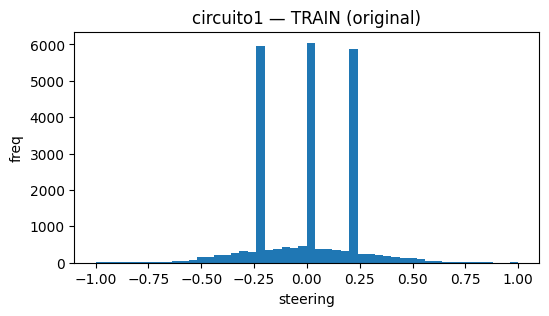

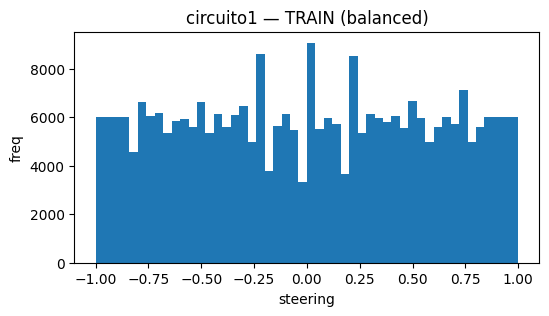

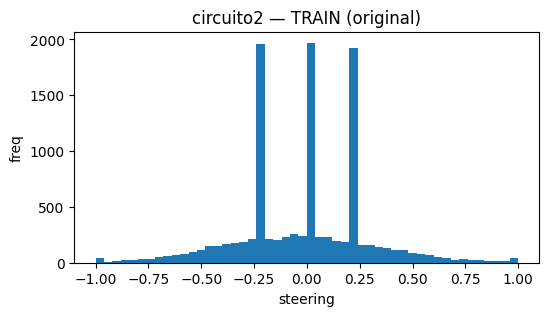

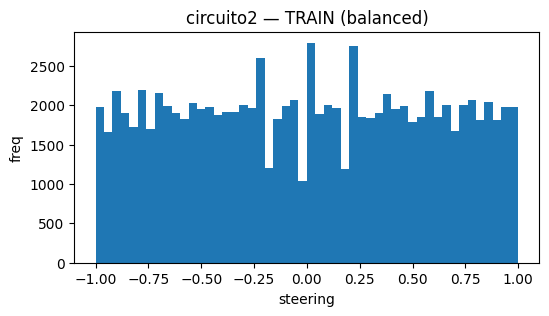

In [4]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd

def plot_hist(csv_path, title, bins):
    df = pd.read_csv(csv_path)
    s = df["steering"].astype(float).clip(-1,1)
    plt.figure(figsize=(6,3))
    plt.hist(s, bins=bins)
    plt.title(title); plt.xlabel("steering"); plt.ylabel("freq")
    plt.show()

for run in RUNS:
    base = PROC / run
    plot_hist(base / "train.csv",             f"{run} — TRAIN (original)",  CFG.bins)
    if (base / "train_balanced.csv").exists():
        plot_hist(base / "train_balanced.csv", f"{run} — TRAIN (balanced)", CFG.bins)


**Listo.** Ya puedes ir a `03_TRAIN_EVAL.ipynb` y activar `USE_OFFLINE_BALANCED = True`
para consumir `tasks_balanced.json` (o dejarlo en `False` si quieres usar `tasks.json`).
